In [164]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plts
import warnings
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def interpolate_to_fixed_points(sorted_curve_bs, target_points=120):
    """
    将 (n, m, 3) 形状的 3D 曲线数据插值为 (n, target_points, 3) 形状的数据。
    
    参数:
    sorted_curve_bs (ndarray): 形状为 (n, m, 3) 的 3D 曲线数据，n 是数据数量，m 是原始每条曲线的点数。
    target_points (int): 插值后的目标点数，默认值为 120。
    
    返回:
    ndarray: 形状为 (n, target_points, 3) 的 3D 插值曲线数据。
    """
    n, m, d = sorted_curve_bs.shape  # (79, 119, 3) 的形状
    interpolated_data = np.zeros((n, target_points, d))  # (n, 120, 3)
    
    for i in range(n):
        for j in range(d):  # 对每个维度 (x, y, z) 单独进行插值
            original_points = sorted_curve_bs[i, :, j]
            original_indices = np.linspace(0, 1, m)  # 原始曲线的归一化位置
            target_indices = np.linspace(0, 1, target_points)  # 目标插值的归一化位置
            interpolator = interp1d(original_indices, original_points, kind='linear')
            interpolated_data[i, :, j] = interpolator(target_indices)  # 在目标点上插值
    
    return interpolated_data

def calculate_curve_length(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线的总长度。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        float: 曲线的总长度。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个差值的欧氏距离，并求和
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    total_length = segment_lengths.sum()
    
    return total_length

def calculate_abscissas(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线每个点的累计弧长（abscissas）。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        numpy.ndarray: 一个形状为 (n,) 的数组，包含每个点对应的累计弧长。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个相邻点对之间的距离
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    
    # 计算累计弧长，起始点的弧长为 0
    abscissas = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    return abscissas

def resample_standardized_curves(standardized_centerlines, standardized_abscissas, m):
    """
    Resample each curve in standardized_centerlines to have exactly m points.

    :param standardized_centerlines: List of (n,3) numpy arrays representing 3D curves.
    :param standardized_abscissas: List of (n,) numpy arrays representing abscissas corresponding to each curve.
    :param m: The number of points each resampled curve should have.
    :return: (new_centerlines, new_abscissas), both resampled to m points.
    """
    new_centerlines = []
    new_abscissas = []

    for i in range(len(standardized_centerlines)):
        curve = standardized_centerlines[i]  # (n,3)
        abscissas = standardized_abscissas[i]  # (n,)

        # 生成新的m个等间距 abscissas
        new_t = np.linspace(abscissas[0], abscissas[-1], m)

        # 分别对 x, y, z 进行插值
        interp_x = interp1d(abscissas, curve[:, 0], kind='cubic', fill_value="extrapolate")
        interp_y = interp1d(abscissas, curve[:, 1], kind='cubic', fill_value="extrapolate")
        interp_z = interp1d(abscissas, curve[:, 2], kind='cubic', fill_value="extrapolate")

        # 计算新的坐标
        new_x = interp_x(new_t)
        new_y = interp_y(new_t)
        new_z = interp_z(new_t)

        # 组合 x, y, z
        new_curve = np.vstack((new_x, new_y, new_z)).T  # (m, 3)

        # 存储结果
        new_centerlines.append(new_curve)
        new_abscissas.append(new_t)

    return new_centerlines, new_abscissas



curve_bs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
curve_cs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
# curve_bs = np.load("../geom_aligned_curves_85/geomstats_aligned_to_first_85.npy")
# curve_cs = np.load("../geom_aligned_curves_85/geomstats_aligned_to_first_85.npy")


curve_bs = interpolate_to_fixed_points(curve_bs, 120)
# unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves_85/total_files_85.npy")[:curve_bs.shape[0]]

print ("curve_bs.shape:", curve_bs.shape)
# print (unaligned_curvatures.shape)
print ("files length:", files.shape[0])

brava_num = len(curve_bs)

original_centerlines = []
abscissas = []
original_lengths = []
curve_ds = [] # curve_ds是用original_length还原长度的curve_bs,好像难以解释它是怎么求得的
standardized_centerlines = []
standardized_abscissas = []
original_tortuosities = []
m=75
for i in range(len(files)):
    # print ("files[i]:", files[i])
    original_centerline = Get_simple_vtk("../"+files[i])
    # print ("original_centerline.shape:", original_centerline.shape)
    # print (calculate_curve_length(original_centerline), calculate_curve_length(curve_bs[i]))
    original_lengths.append(calculate_curve_length(original_centerline))
    original_centerlines.append(original_centerline)
    abscissas.append(calculate_abscissas(original_centerline))
    curve_ds.append(curve_bs[i] * calculate_curve_length(original_centerline))
    original_tortuosities.append(calculate_curve_length(original_centerline)/np.linalg.norm(original_centerline[-1]-original_centerline[0]))
print ("所有中心线的original长度的均值是",np.mean(original_lengths), "标准差是", np.std(original_lengths))

for i in range(len(files)):
    standardized_centerlines.append(original_centerlines[i]*np.mean(original_lengths)/original_lengths[i])
    standardized_abscissas.append(abscissas[i]*np.mean(original_lengths)/original_lengths[i])

resampled_standardized_centerlines, resampled_standardized_abscissas = resample_standardized_curves(standardized_centerlines, standardized_abscissas, m)


original_centerlines = np.array(original_centerlines)
abscissas = np.array(abscissas)
original_lengths = np.array(original_lengths)
original_tortuosities = np.array(original_tortuosities)
curve_ds = np.array(curve_ds)
resampled_standardized_centerlines = np.array(resampled_standardized_centerlines)
resampled_standardized_abscissas = np.array(resampled_standardized_abscissas)

files_label = []
for i in range(len(files)):
    files_label.append("_".join([files[i].split('\\')[-1].split('.')[0].split('_')[0],files[i].split('\\')[-1].split('.')[0].split('_')[-1]]))

# print (files_label)

original_centerlines_copy = np.copy(original_centerlines)
resampled_standardized_centerlines_copy = np.copy(resampled_standardized_centerlines)




curve_bs.shape: (79, 120, 3)
files length: 79
所有中心线的original长度的均值是 75.07954866493863 标准差是 7.8380290981959195


mean_estimate.shape: (119, 3)
curve_bs.shape: (79, 119, 3)


<Figure size 600x200 with 0 Axes>

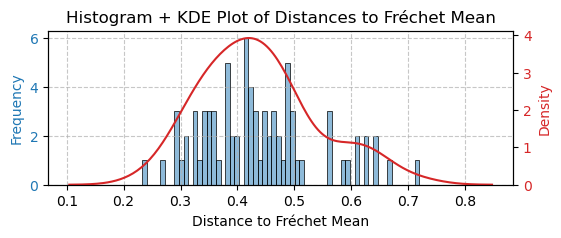

<Figure size 600x200 with 0 Axes>

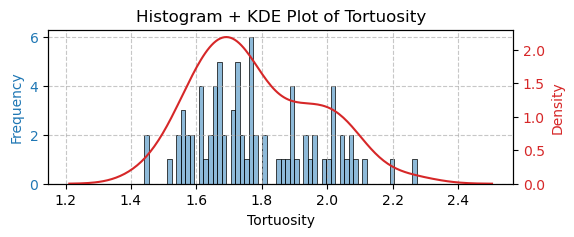

<Figure size 600x200 with 0 Axes>

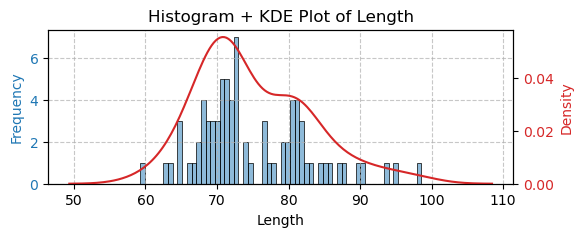

In [183]:
k_sampling_points = 120

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=True
)

curves_r3.equip_with_metric(SRVMetric)
curves_r3.equip_with_group_action(("rotations", "reparametrizations"))
curves_r3.equip_with_quotient()
mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_

print ("mean_estimate.shape:", mean_estimate.shape) # mean_estimate.shape: (120, 3)
print ("curve_bs.shape:", curve_cs.shape) # curve_bs.shape: (79, 120, 3)
g_dist_to_frechet = []
for i in range(len(curve_cs)):
    g_dist_to_frechet.append(curves_r3.metric.dist(mean_estimate, curve_cs[i]))
g_dist_to_frechet = np.array(g_dist_to_frechet)


bins = 60
plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

# 直方图（频数）
sns.histplot(g_dist_to_frechet, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Distance to Fréchet Mean")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# KDE曲线（密度）- 第二个y轴
ax2 = ax1.twinx()
sns.kdeplot(g_dist_to_frechet, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Distances to Fréchet Mean")
plt.show()

plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_tortuosities, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Tortuosity")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_tortuosities, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Tortuosity")
plt.show()

plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_lengths, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Length")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_lengths, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Length")
plt.show()


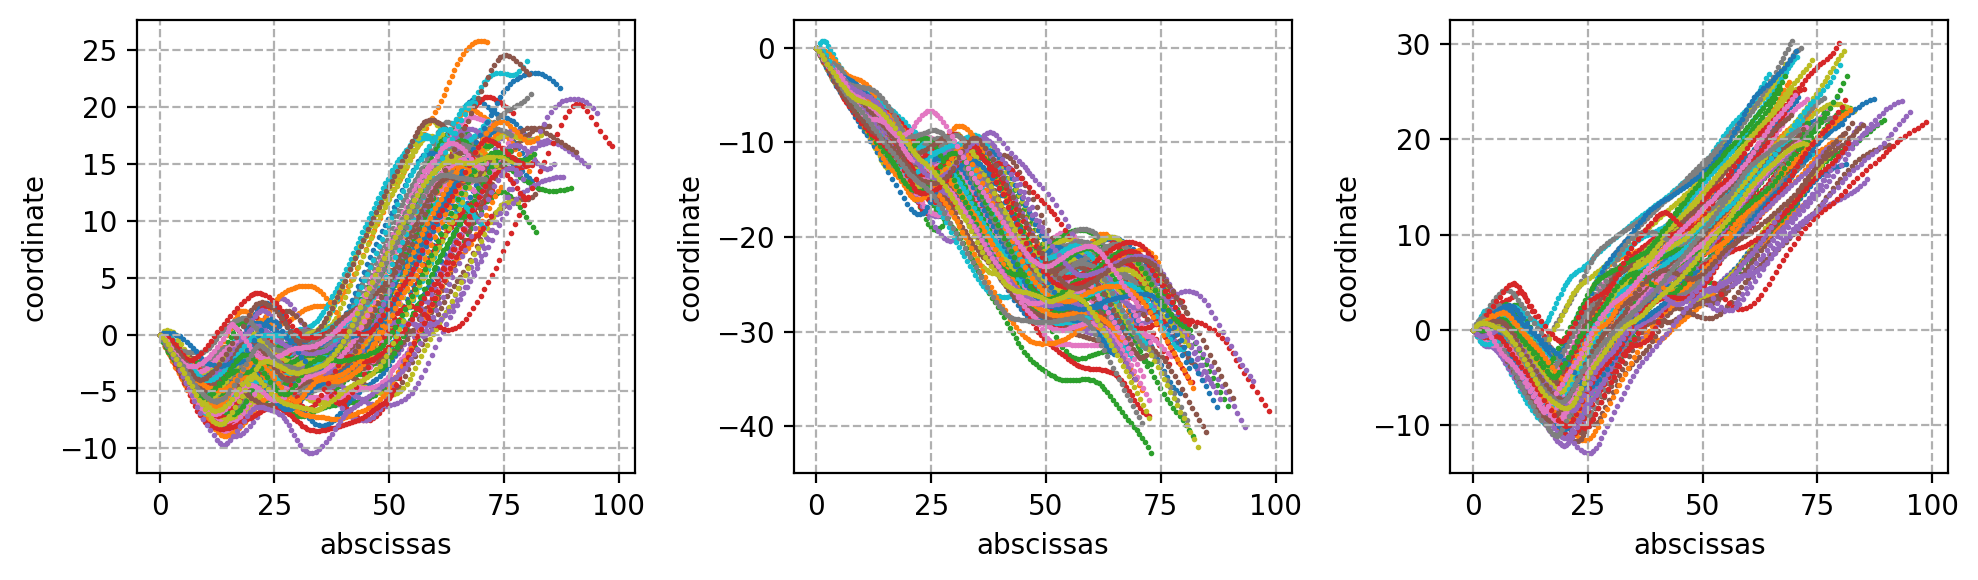

original_centerlines shape: (79, 120, 3)
abscissas shape: (79, 120)


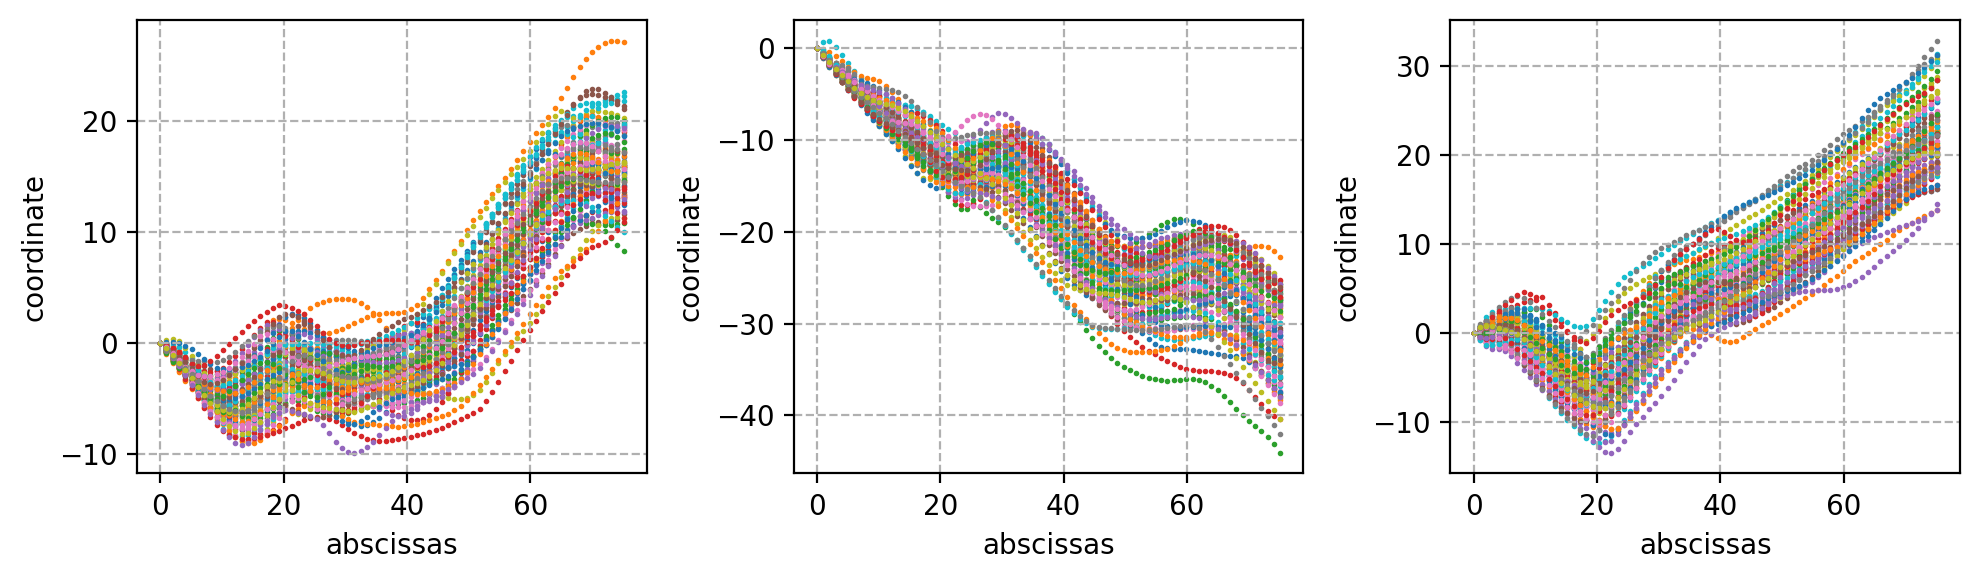

original_centerlines shape: (79, 75, 3)
abscissas shape: (79, 75)


In [166]:
fig = plt.figure(figsize=(10,3), dpi=200)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for i in range(len(original_centerlines)):
    ax1.scatter(abscissas[i],original_centerlines_copy[i][:,0],marker='o',s=1)
    ax2.scatter(abscissas[i],original_centerlines_copy[i][:,1],marker='o',s=1)
    ax3.scatter(abscissas[i],original_centerlines_copy[i][:,2],marker='o',s=1)

for  ax in [ax1, ax2, ax3]:
    ax.set_xlabel("abscissas")
    ax.set_ylabel("coordinate")
    ax.grid(linestyle="--")
plt.tight_layout()
plt.show()

print ("original_centerlines shape:", original_centerlines_copy.shape)
print ("abscissas shape:", abscissas.shape)

# 插值到1mm/point,缩放

fig = plt.figure(figsize=(10,3), dpi=200)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for i in range(len(original_centerlines)):
    ax1.scatter(resampled_standardized_abscissas[i],resampled_standardized_centerlines_copy[i][:,0],marker='o',s=1)
    ax2.scatter(resampled_standardized_abscissas[i],resampled_standardized_centerlines_copy[i][:,1],marker='o',s=1)
    ax3.scatter(resampled_standardized_abscissas[i],resampled_standardized_centerlines_copy[i][:,2],marker='o',s=1)

for  ax in [ax1, ax2, ax3]:
    ax.set_xlabel("abscissas")
    ax.set_ylabel("coordinate")
    ax.grid(linestyle="--")
plt.tight_layout()
plt.show()

print ("original_centerlines shape:", resampled_standardized_centerlines.shape)
print ("abscissas shape:", resampled_standardized_abscissas.shape)

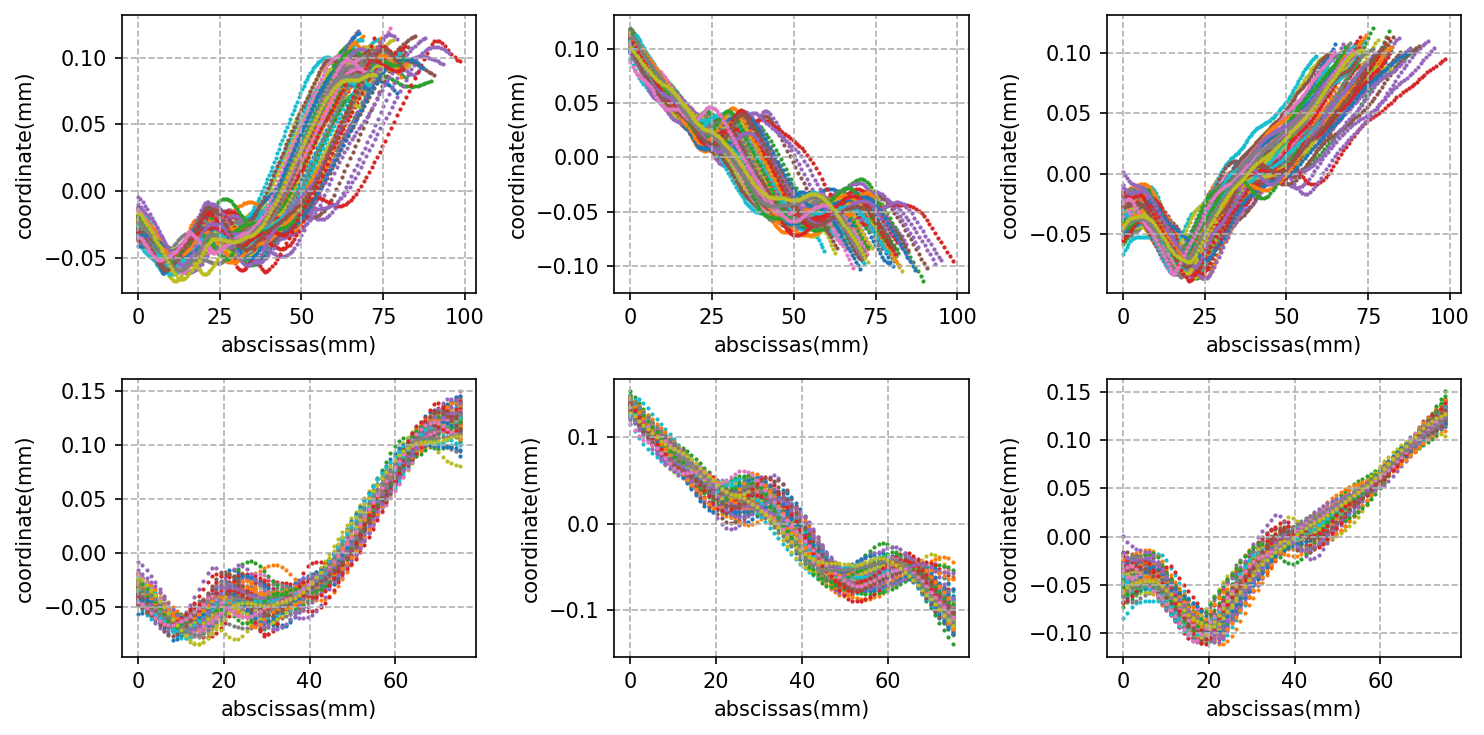

In [167]:
# After aligning the curves, we can visualize the aligned curves in 3D space.

from scipy.spatial import procrustes

def align_centerlines_procrustes(original_centerlines):
    num_curves, num_points, dim = original_centerlines.shape
    
    # 选择第一条曲线作为参考
    reference_curve = original_centerlines[0]

    aligned_centerlines = np.zeros_like(original_centerlines)

    for i in range(num_curves):
        _, aligned_curve, _ = procrustes(reference_curve, original_centerlines[i])
        aligned_centerlines[i] = aligned_curve

    return aligned_centerlines

original_centerlines = align_centerlines_procrustes(original_centerlines)
resampled_standardized_centerlines = align_centerlines_procrustes(resampled_standardized_centerlines)

# 可视化对齐后的曲线
fig = plt.figure(figsize=(10,5), dpi=150)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


for i in range(len(original_centerlines)):
    ax1.scatter(abscissas[i], original_centerlines[i][:, 0], marker='o', s=1)
    ax2.scatter(abscissas[i], original_centerlines[i][:, 1], marker='o', s=1)
    ax3.scatter(abscissas[i], original_centerlines[i][:, 2], marker='o', s=1)
    ax4.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 0], marker='o', s=1)
    ax5.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 1], marker='o', s=1)
    ax6.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 2], marker='o', s=1)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel("abscissas(mm)")
    ax.set_ylabel("coordinate(mm)")
    ax.grid(linestyle="--")

plt.tight_layout()
plt.show()




interpolated_std_centerlines shape: (79, 751, 3)
interval:, 0.1 explained_variance_ratio_: [0.27556965 0.17629441 0.1051829  0.08660831 0.07557015 0.05754506
 0.0503335  0.03420369 0.02735532 0.01944741]
interpolated_std_centerlines shape: (79, 251, 3)
interval:, 0.3 explained_variance_ratio_: [0.27563657 0.17576382 0.10538441 0.08665115 0.07548555 0.05753194
 0.05021437 0.03413499 0.02747753 0.01941818]
interpolated_std_centerlines shape: (79, 76, 3)
interval:, 1.0 explained_variance_ratio_: [0.27577333 0.17398289 0.10610804 0.08667054 0.07513335 0.0576095
 0.04973607 0.03386271 0.02791418 0.01933482]
interpolated_std_centerlines shape: (79, 26, 3)
interval:, 3.0 explained_variance_ratio_: [0.27692549 0.16904856 0.10821797 0.08600891 0.07445303 0.05793721
 0.04783063 0.03294852 0.02951849 0.01921378]
(4, 79, 10)


C:\Users\cheno\AppData\Local\Temp\ipykernel_28460\3334905888.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_28460\3334905888.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


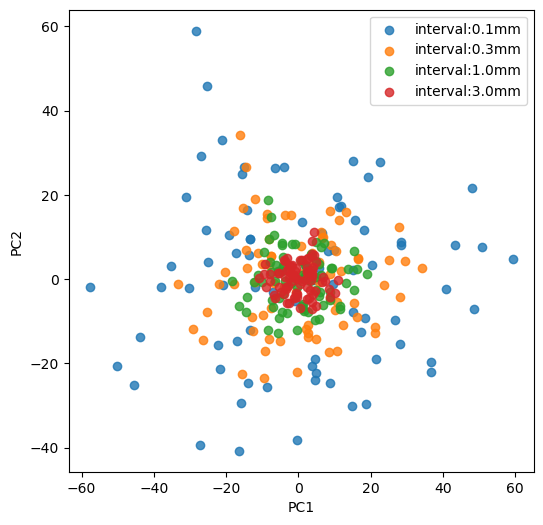

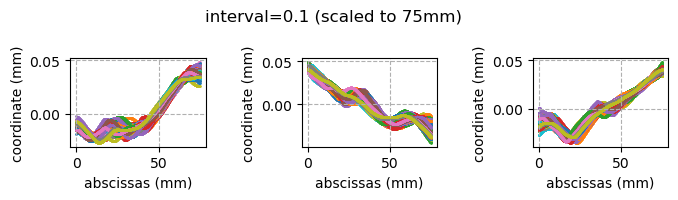

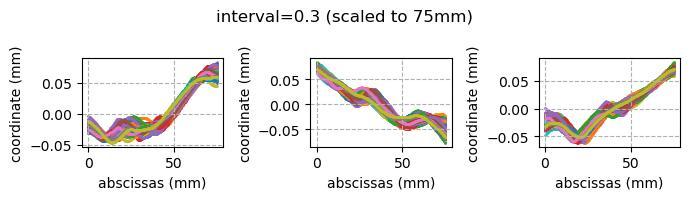

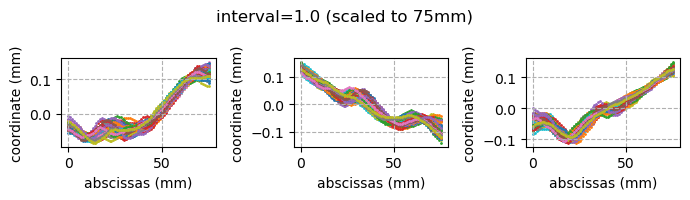

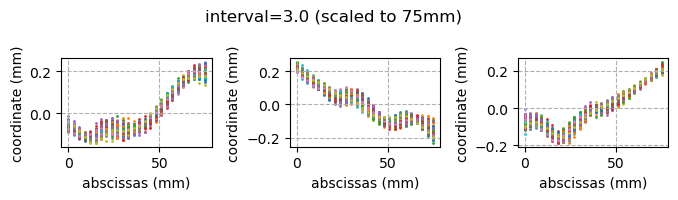

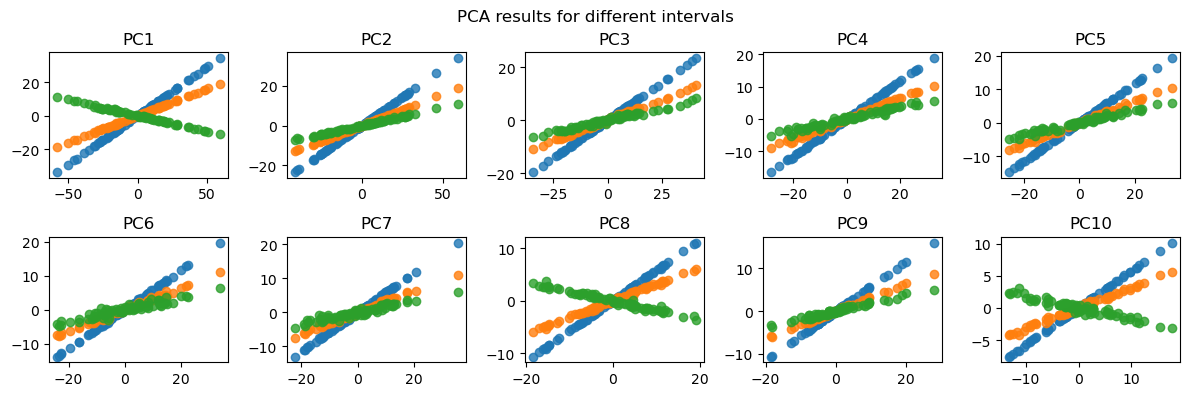

In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

n_components = 10
def resample_centerlines_by_interval(abscissas, original_centerlines, interval):
    num_curves, num_points = abscissas.shape
    
    resampled_centerlines = []
    resampled_abscissas = []

    for i in range(num_curves):
        # 获取当前曲线的abscissas和centerlines
        x = abscissas[i]
        y = original_centerlines[i]

        # 确保 x 是单调递增的
        if not np.all(np.diff(x) > 0):
            raise ValueError(f"abscissas[{i}] 不是严格单调递增的")

        # 生成新的采样点
        new_x = np.arange(x[0], x[-1], interval)
        resampled_abscissas.append(new_x)

        # 对 centerlines 进行插值
        interp_func = interp1d(x, y, axis=0, kind='linear', fill_value='extrapolate')
        new_y = interp_func(new_x)
        resampled_centerlines.append(new_y)

    return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)

fig1 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111)

std_results = []
interval_var =[0.1,0.3,1.0,3.0]
for interval in interval_var:
    fig2 = plt.figure(figsize=(7,2), dpi=100)
    fig2.suptitle(f"interval={interval} (scaled to 75mm)")
    ax2_1 = fig2.add_subplot(131)
    ax2_2 = fig2.add_subplot(132)
    ax2_3 = fig2.add_subplot(133)
    for  ax in [ax2_1, ax2_2, ax2_3]:
        ax.set_xlabel("abscissas (mm)")
        ax.set_ylabel("coordinate (mm)")
        ax.grid(linestyle="--")
    interpolated_std_abscissas, interpolated_std_centerlines = resample_centerlines_by_interval(resampled_standardized_abscissas, 
                                                                                        resampled_standardized_centerlines, 
                                                                                        interval)
    interpolated_std_centerlines = align_centerlines_procrustes(interpolated_std_centerlines)
    print ("interpolated_std_centerlines shape:", interpolated_std_centerlines.shape)
    for j in range(len(interpolated_std_centerlines)):
        ax2_1.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 0], marker='o', s=1)
        ax2_2.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 1], marker='o', s=1)
        ax2_3.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 2], marker='o', s=1)
    X = interpolated_std_centerlines.reshape(79, -1)
    fig2.tight_layout(rect=[0, 0, 1, 0.96])
    # 进行标准化 (Z-score)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # 进行 PCA
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(X_scaled)
    std_results.append(result)
    print ("interval:,",interval,"explained_variance_ratio_:", pca.explained_variance_ratio_)

    ax1.scatter(result[:, 0], result[:, 1], alpha=.8, label="interval:"+str(interval)+"mm")
    
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend()
fig1.show()

std_results = np.array(std_results)
print (std_results.shape)

fig,axes = plt.subplots(2,5,figsize=(12,4))
axes = axes.flatten()
for i in range(n_components):
    for j in range(1,len(std_results)):
        axes[i].scatter(std_results[0][:, i], std_results[j][:, i], label=f"iv={interval_var[j]}",alpha=.8)
        axes[i].set_title(f"PC{i+1}")
        # axes[i].legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("PCA results for different intervals") 
fig.show()

C:\Users\cheno\AppData\Local\Temp\ipykernel_28460\3400914667.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_28460\3400914667.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_28460\3400914667.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_28460\3400914667.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


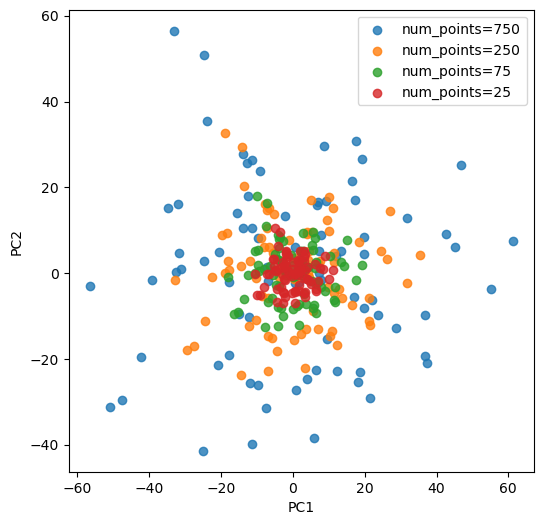

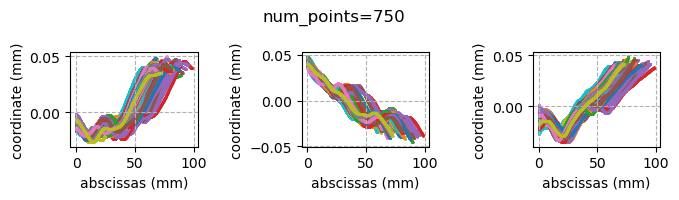

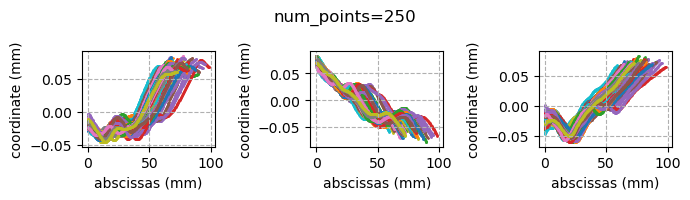

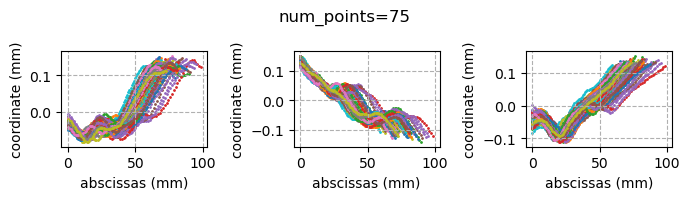

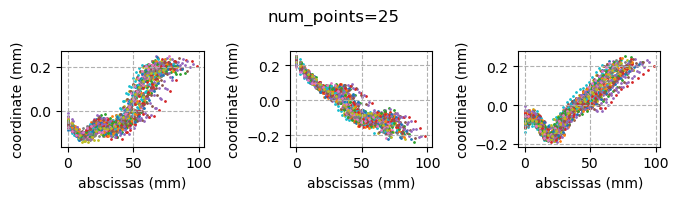

C:\Users\cheno\AppData\Local\Temp\ipykernel_28460\3400914667.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


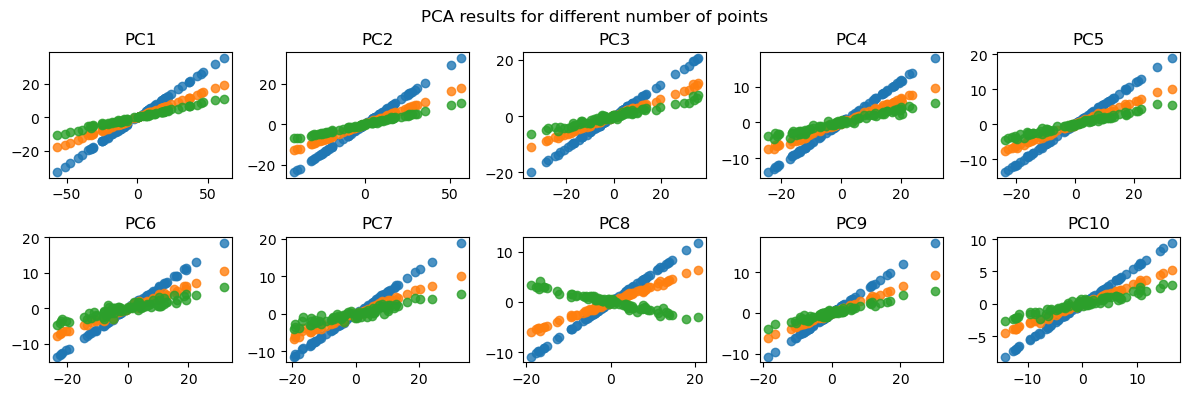

In [169]:
n_components = 10

def resample_centerlines_by_points(abscissas, original_centerlines, num_points):
    num_curves, num_original_points = abscissas.shape

    resampled_centerlines = []
    resampled_abscissas = []

    for i in range(num_curves):
        x = abscissas[i]
        y = original_centerlines[i]

        if not np.all(np.diff(x) > 0):
            raise ValueError(f"abscissas[{i}] 不是严格单调递增的")

        # 生成新的等间距 abscissas（保持原始范围）
        new_x = np.linspace(x[0], x[-1], num_points)

        # 对 centerlines 进行插值
        curve_func = parameterize_curve(y)
        new_y = curve_func(np.linspace(0, 1, num_points))  # 按参数化均匀采样

        resampled_abscissas.append(new_x)
        resampled_centerlines.append(new_y)

    return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)

original_resampling_data = {}
non_std_results = []

fig_pca = plt.figure(figsize=(6, 6), dpi=100)
ax_pca = fig_pca.add_subplot(111)

points_var =[750, 250, 75, 25]
for num_points in points_var:
    new_abscissas, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=num_points)
    original_resampling_data[num_points] = (new_abscissas, new_centerlines)
    new_centerlines = align_centerlines_procrustes(new_centerlines)
    X = new_centerlines.reshape(79, -1)
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(X_scaled)
    ax_pca.scatter(result[:, 0], result[:, 1], label=f"num_points={num_points}",alpha=.8)
    non_std_results.append(result)


    fig = plt.figure(figsize=(7, 2), dpi=100)
    fig.suptitle(f"num_points={num_points}")
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    for i in range(len(original_centerlines)):
        ax1.scatter(new_abscissas[i], new_centerlines[i][:, 0], marker='o', s=1)
        ax2.scatter(new_abscissas[i], new_centerlines[i][:, 1], marker='o', s=1)
        ax3.scatter(new_abscissas[i], new_centerlines[i][:, 2], marker='o', s=1)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel("abscissas (mm)")
        ax.set_ylabel("coordinate (mm)")
        ax.grid(linestyle="--")

    fig.tight_layout()
    fig.show()
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")
ax_pca.legend()
plt.show(fig_pca)

fig,axes = plt.subplots(2,5,figsize=(12,4))
axes = axes.flatten()
for i in range(n_components):
    for j in range(1,len(non_std_results)):
        axes[i].scatter(non_std_results[0][:, i], non_std_results[j][:, i], label=f"n_pts={points_var[j]}",alpha=.8)
        axes[i].set_title(f"PC{i+1}")
        # axes[i].legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("PCA results for different number of points")
fig.show()



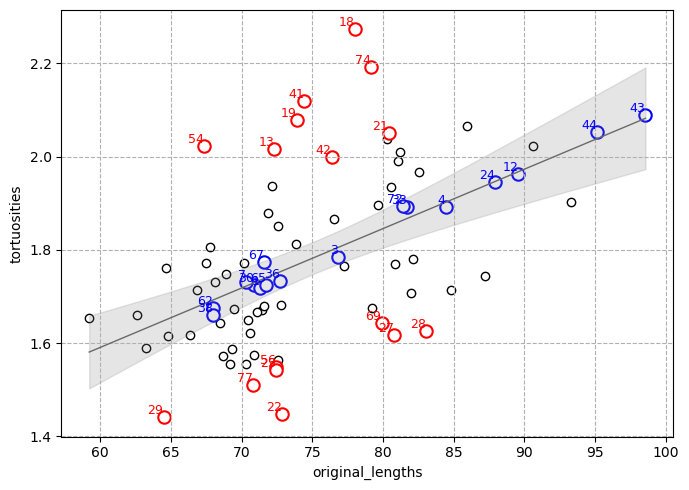

Confidence interval width at x=78.893: 0.077
Indices of points farthest from the line: [56 42 21 69 29 23 77 27 28 13 22 19 54 41 74 18]
Indices of points closest to the line: [24 30 12 43  7  4 44  1 65 62 36  3 33 72 38 67]
24 brava_cut_mirrored\BG0020_ICA_L.vtk
30 brava_cut_mirrored\BH0005_ICA_R.vtk
12 brava_cut_mirrored\BG0010_ICA_L.vtk
43 brava_cut_mirrored\BH0016_ICA_L.vtk
7 brava_cut_mirrored\BG0007_ICA_R.vtk
4 brava_cut_mirrored\BG0006_ICA_L.vtk
44 brava_cut_mirrored\BH0016_ICA_R.vtk
1 brava_cut_mirrored\BG0001_ICA_R.vtk
65 brava_cut_mirrored\BH0031_ICA_R.vtk
62 brava_cut_mirrored\BH0030_ICA_L.vtk
36 brava_cut_mirrored\BH0010_ICA_R.vtk
3 brava_cut_mirrored\BG0004_ICA_R.vtk
33 brava_cut_mirrored\BH0009_ICA_L.vtk
72 brava_cut_mirrored\BH0038_ICA_L.vtk
38 brava_cut_mirrored\BH0011_ICA_R.vtk
67 brava_cut_mirrored\BH0034_ICA_R.vtk


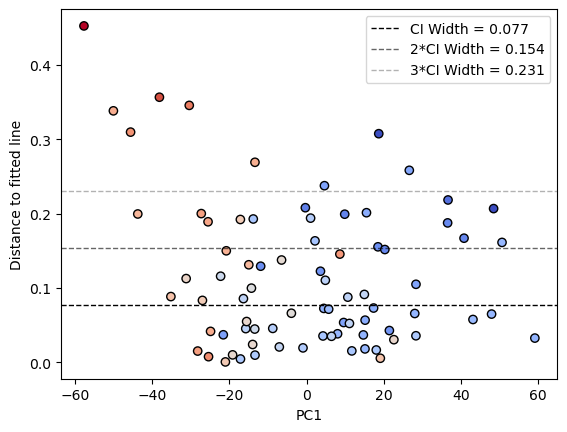

In [170]:
n_highlight = 16  # 需要标出的离散点数量
n_closest = 16  # 需要标出的最近点数量

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

# 绘制散点图
sc = ax.scatter(original_lengths, original_tortuosities, color='w', edgecolors='k')
ax.set_ylabel("tortuosities")
ax.set_xlabel("original_lengths")
ax.grid(linestyle="--")

# 线性回归 - statsmodels
X = sm.add_constant(original_lengths)
model = sm.OLS(original_tortuosities, X).fit()

# 获取拟合直线上的 y 值
y_fitted = model.predict(X)

# 计算残差（垂直距离，带符号）
residuals = original_tortuosities - y_fitted

# 找到离直线最远的 n 个点的索引
sorted_indices = np.argsort(np.abs(residuals))[-n_highlight:]

# 标出最远的 n 个点，用红色边框
for idx in sorted_indices:
    ax.scatter(original_lengths[idx], original_tortuosities[idx], facecolor='w', edgecolor='red', s=80, linewidth=1.5)
    ax.text(original_lengths[idx], original_tortuosities[idx], str(idx), fontsize=9, ha='right', va='bottom', color='red')
# 找到离直线最近的 n 个点的索引
closest_indices = np.argsort(np.abs(residuals))[:n_closest]

# 标出最近的 n 个点，用蓝色边框
for idx in closest_indices:
    ax.scatter(original_lengths[idx], original_tortuosities[idx], facecolor='w', edgecolor='blue', s=80, linewidth=1.5)
    ax.text(original_lengths[idx], original_tortuosities[idx], str(idx), fontsize=9, ha='right', va='bottom', color='blue')

# 绘制拟合直线
x_fit = np.linspace(min(original_lengths), max(original_lengths), 100)
X_fit = sm.add_constant(x_fit)
y_fit = model.predict(X_fit)
ax.plot(x_fit, y_fit, color='dimgray', linestyle='-', linewidth=1, label="Fitted Line")

# 获取置信区间 (95%)
pred = model.get_prediction(X_fit)
conf_int = pred.conf_int(alpha=0.05)  # (100, 2)

# 绘制置信区间
ax.fill_between(x_fit, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label="95% Confidence Interval")

plt.tight_layout()
plt.show()

# 计算 x 轴中点处的置信区间宽度
x_mid = np.median(x_fit)
X_mid = np.array([[1, x_mid]])  # 手动组合常数项和 x 值

y_mid_pred = model.predict(X_mid)[0]

# 注意这里也用 X_mid，不要再调用 sm.add_constant()
conf_int_mid = model.get_prediction(X_mid).conf_int(alpha=0.05)[0]
conf_int_width = conf_int_mid[1] - conf_int_mid[0]

print(f"Confidence interval width at x={x_mid:.3f}: {conf_int_width:.3f}")



print("Indices of points farthest from the line:", sorted_indices)
print("Indices of points closest to the line:", closest_indices)
for idx in closest_indices:
    print(idx, files[idx])

def get_distances_to_fit(original_lengths, original_tortuosities):
    # 线性回归 - statsmodels
    X = sm.add_constant(original_lengths)
    model = sm.OLS(original_tortuosities, X).fit()

    # 计算残差（带符号距离）
    y_fitted = model.predict(X)
    residuals = original_tortuosities - y_fitted  # 每个点到拟合直线的垂直距离（正负）

    return residuals

distances = get_distances_to_fit(original_lengths, original_tortuosities)
abs_distances = np.abs(distances)

plt.scatter(std_results[0][:, 0], abs_distances, c=original_tortuosities, cmap='coolwarm', edgecolors='k')
plt.axhline(y=conf_int_width, color='k', linestyle='--', linewidth=1, label=f"CI Width = {conf_int_width:.3f}")
plt.axhline(y=2*conf_int_width, color='k', linestyle='--', linewidth=1, label=f"2*CI Width = {2*conf_int_width:.3f}",alpha=0.6)
plt.axhline(y=3*conf_int_width, color='k', linestyle='--', linewidth=1, label=f"3*CI Width = {3*conf_int_width:.3f}",alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("Distance to fitted line")
plt.legend()
plt.show()


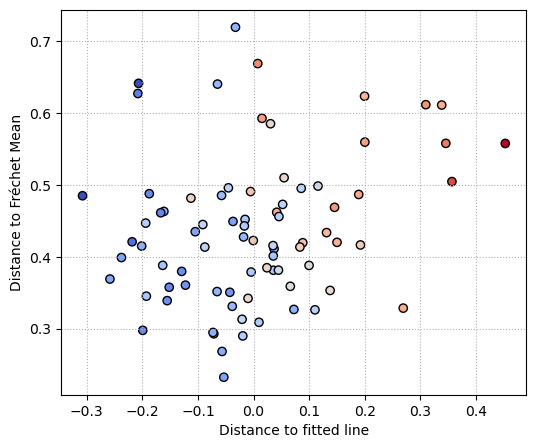

In [176]:
fig = plt.figure(figsize=(6, 5), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(distances, g_dist_to_frechet, c=original_tortuosities, cmap='coolwarm', edgecolors='k')
ax.set_xlabel("Distance to fitted line")
ax.set_ylabel("Distance to Fréchet Mean")
ax.grid(linestyle=":")
plt.show()

X shape: (79, 225)
PCA transformed shape: (79, 10)


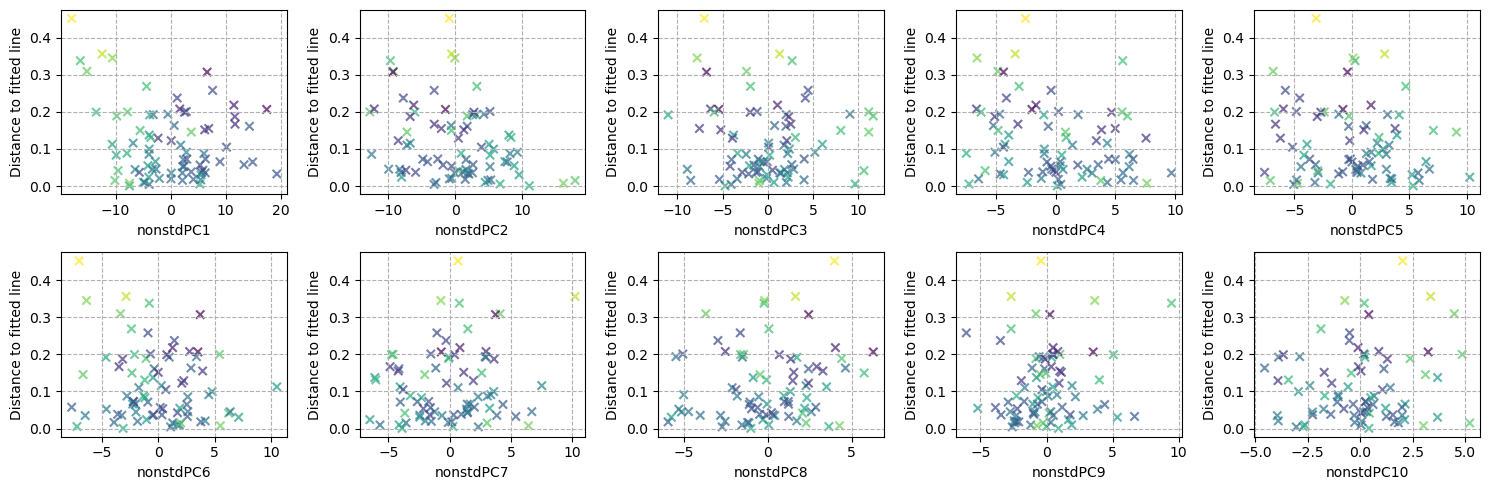

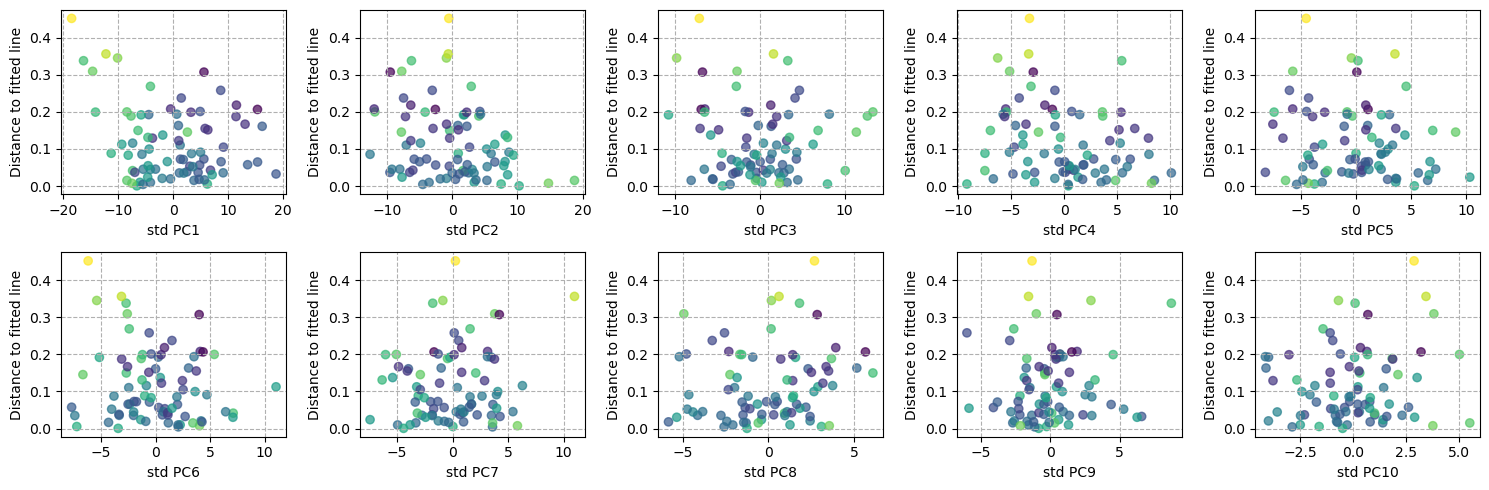

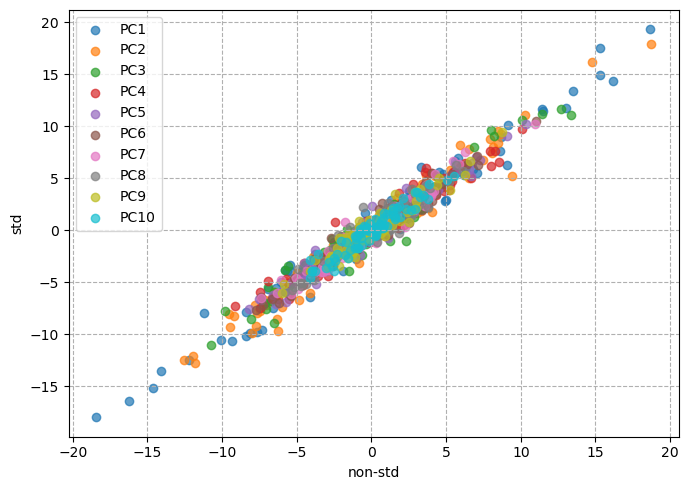

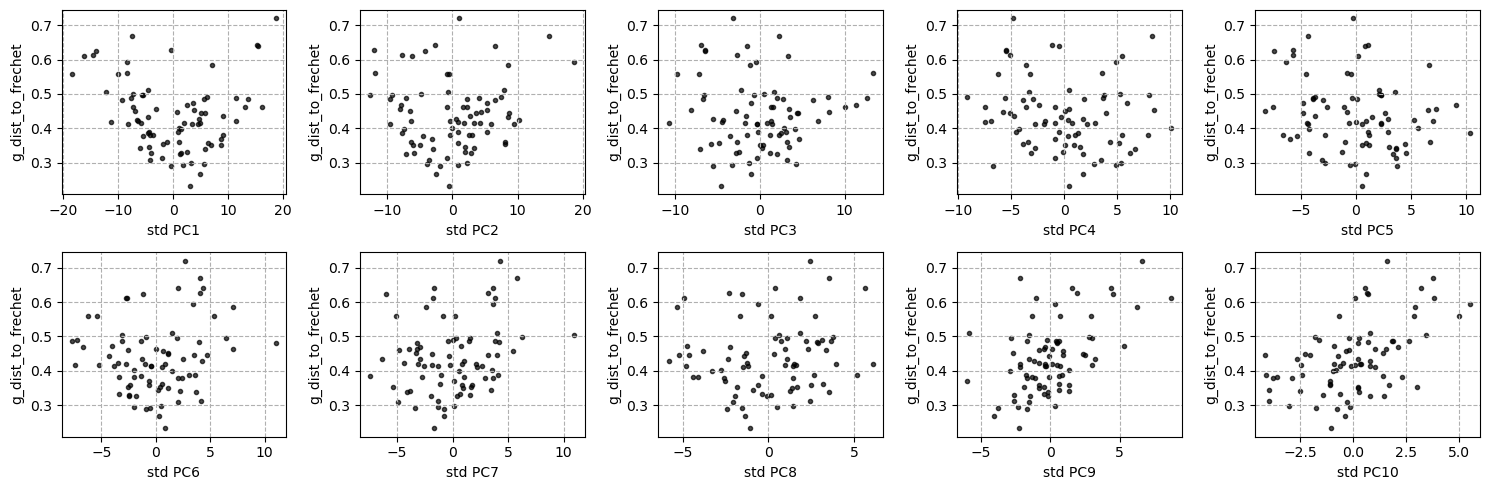

In [171]:
# 将数据 reshape 为 (79, 3*m)
X = resampled_standardized_centerlines.reshape(79, -1) # 标准化到75mm的centerlines
print ("X shape:", X.shape)

# 进行标准化 (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 进行 PCA
std_pca = PCA(n_components=n_components)
std_pca_result = std_pca.fit_transform(X_scaled)

print("PCA transformed shape:", std_pca_result.shape)  # (79, 3)

_, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=75)
new_centerlines = np.array(new_centerlines)
X = new_centerlines.reshape(79, -1)
X_scaled = StandardScaler().fit_transform(X)

non_std_pca = PCA(n_components=n_components)
non_std_pca_result = non_std_pca.fit_transform(X_scaled)


fig, axes = plt.subplots(2, 5, figsize=(15, 5), dpi=100)
axes = axes.flatten()
for i in range(n_components):
    ax = axes[i]
    # ax.scatter(std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='o')
    ax.scatter(non_std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='x')
    ax.set_ylabel("Distance to fitted line")
    ax.set_xlabel(f"nonstdPC{i+1}")
    ax.grid(linestyle="--")

plt.tight_layout()    
plt.show()


fig, axes = plt.subplots(2, 5, figsize=(15, 5), dpi=100)
axes = axes.flatten()
for i in range(n_components):
    ax = axes[i]
    ax.scatter(std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='o')
    # ax.scatter(non_std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='x')
    ax.set_ylabel("Distance to fitted line")
    ax.set_xlabel(f"std PC{i+1}")
    ax.grid(linestyle="--")

plt.tight_layout()    
plt.show()



fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
for i in range(n_components):
    ax.scatter(std_pca_result[:, i], non_std_pca_result[:, i], label=f"PC{i+1}", alpha=0.7, marker='o')
ax.set_ylabel("std")
ax.set_xlabel("non-std")
ax.grid(linestyle="--")
ax.legend()
plt.tight_layout()    
plt.show()


fig, axes = plt.subplots(2, 5, figsize=(15, 5), dpi=100)
axes = axes.flatten()
for i in range(n_components):
    ax = axes[i]
    ax.scatter(std_pca_result[:, i], g_dist_to_frechet, label=f"PC{i+1}", alpha=0.7, c='k',marker='.')
    ax.set_ylabel("g_dist_to_frechet")
    ax.set_xlabel(f"std PC{i+1}")
    ax.grid(linestyle="--")

plt.tight_layout()    
plt.show()


features shape: (79, 283)


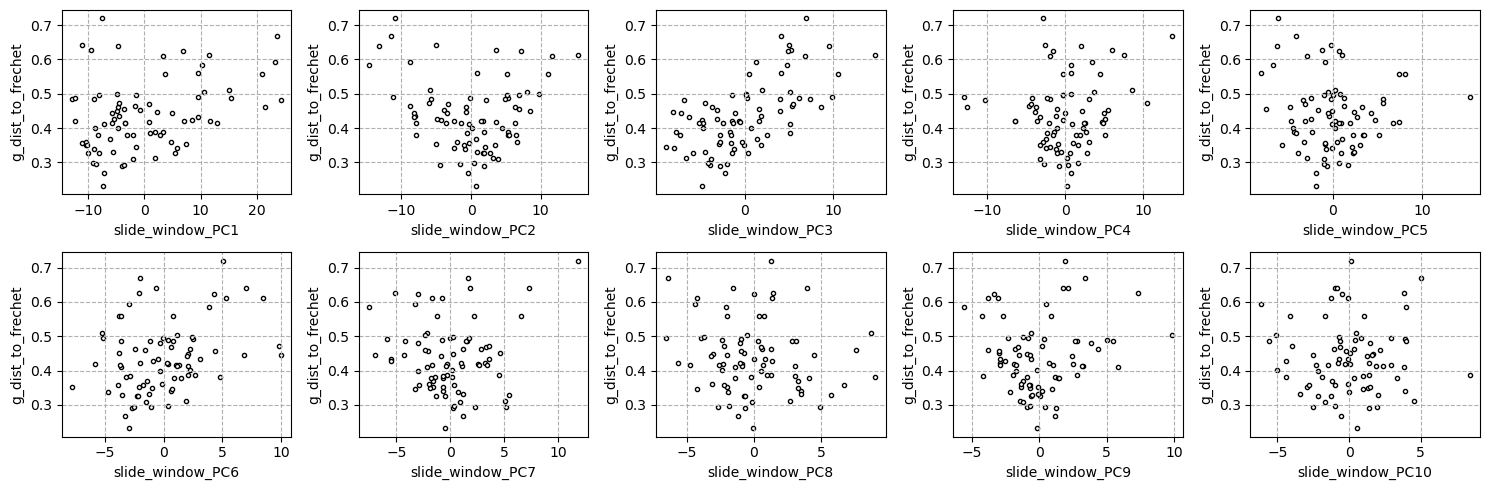

In [172]:
import numpy as np

def compute_tortuosity(segment):
    """
    计算一段3D曲线segment的tortuosity
    segment: (window_size, 3)
    """
    L_curve = np.sum(np.linalg.norm(np.diff(segment, axis=0), axis=1))
    L_straight = np.linalg.norm(segment[-1] - segment[0])
    return L_curve / L_straight if L_straight > 0 else 1.0

def extract_tortuosity_features(original_centerlines, window_sizes):
    """
    original_centerlines: (n, m, 3) n条曲线，每条m个3D点
    window_sizes: list of int, 不同窗口大小
    返回:
    features: list of np.ndarray，每条曲线对应一个拼接后的tortuosity feature vector
    """
    n, m, _ = original_centerlines.shape
    features = []

    for i in range(n):
        curve = original_centerlines[i]
        curve_features = []

        for window_size in window_sizes:
            for j in range(m - window_size + 1):
                segment = curve[j : j + window_size]
                tortuosity = compute_tortuosity(segment)
                curve_features.append(tortuosity)

        features.append(np.array(curve_features))

    return features

window_sizes = [10,20,50]
features = extract_tortuosity_features(original_centerlines, window_sizes)
print ("features shape:", np.array(features).shape)

slide_window_pca = PCA(n_components=10)
scaled_features = StandardScaler().fit_transform(features)
slide_window_pca_result = slide_window_pca.fit_transform(scaled_features)


fig, axes = plt.subplots(2, 5, figsize=(15, 5), dpi=100)
axes = axes.flatten()
for i in range(n_components):
    ax = axes[i]
    ax.grid(linestyle="--")
    ax.scatter(slide_window_pca_result[:, i], g_dist_to_frechet, marker='.', color='w', edgecolors='k')
    ax.set_ylabel("g_dist_to_frechet")
    ax.set_xlabel(f"slide_window_PC{i+1}")
    

plt.tight_layout()    
plt.show()


fig = plt.figure(figsize=(7, 5), dpi=3100)
ax = fig.add_subplot(111)
ax.imshow(features, cmap='coolwarm')
plt.show()